In [1]:
from functools import partial
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import PIL
import torch
import torch.nn.functional as nnf

from diffusers import DDIMScheduler, StableDiffusionPipeline

path = "~/models/stable-diffusion-v1-4"
path = Path(path).expanduser()

from PIL import Image
from torchvision import transforms

import inspect
from typing import Callable, List, Optional, Union

import torch
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import \
    StableDiffusionSafetyChecker
from diffusers.schedulers import DDIMScheduler,PNDMScheduler, LMSDiscreteScheduler
from diffusers.utils import deprecate, logging

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

# ddim forward step & backward step 
from https://arxiv.org/abs/2105.05233

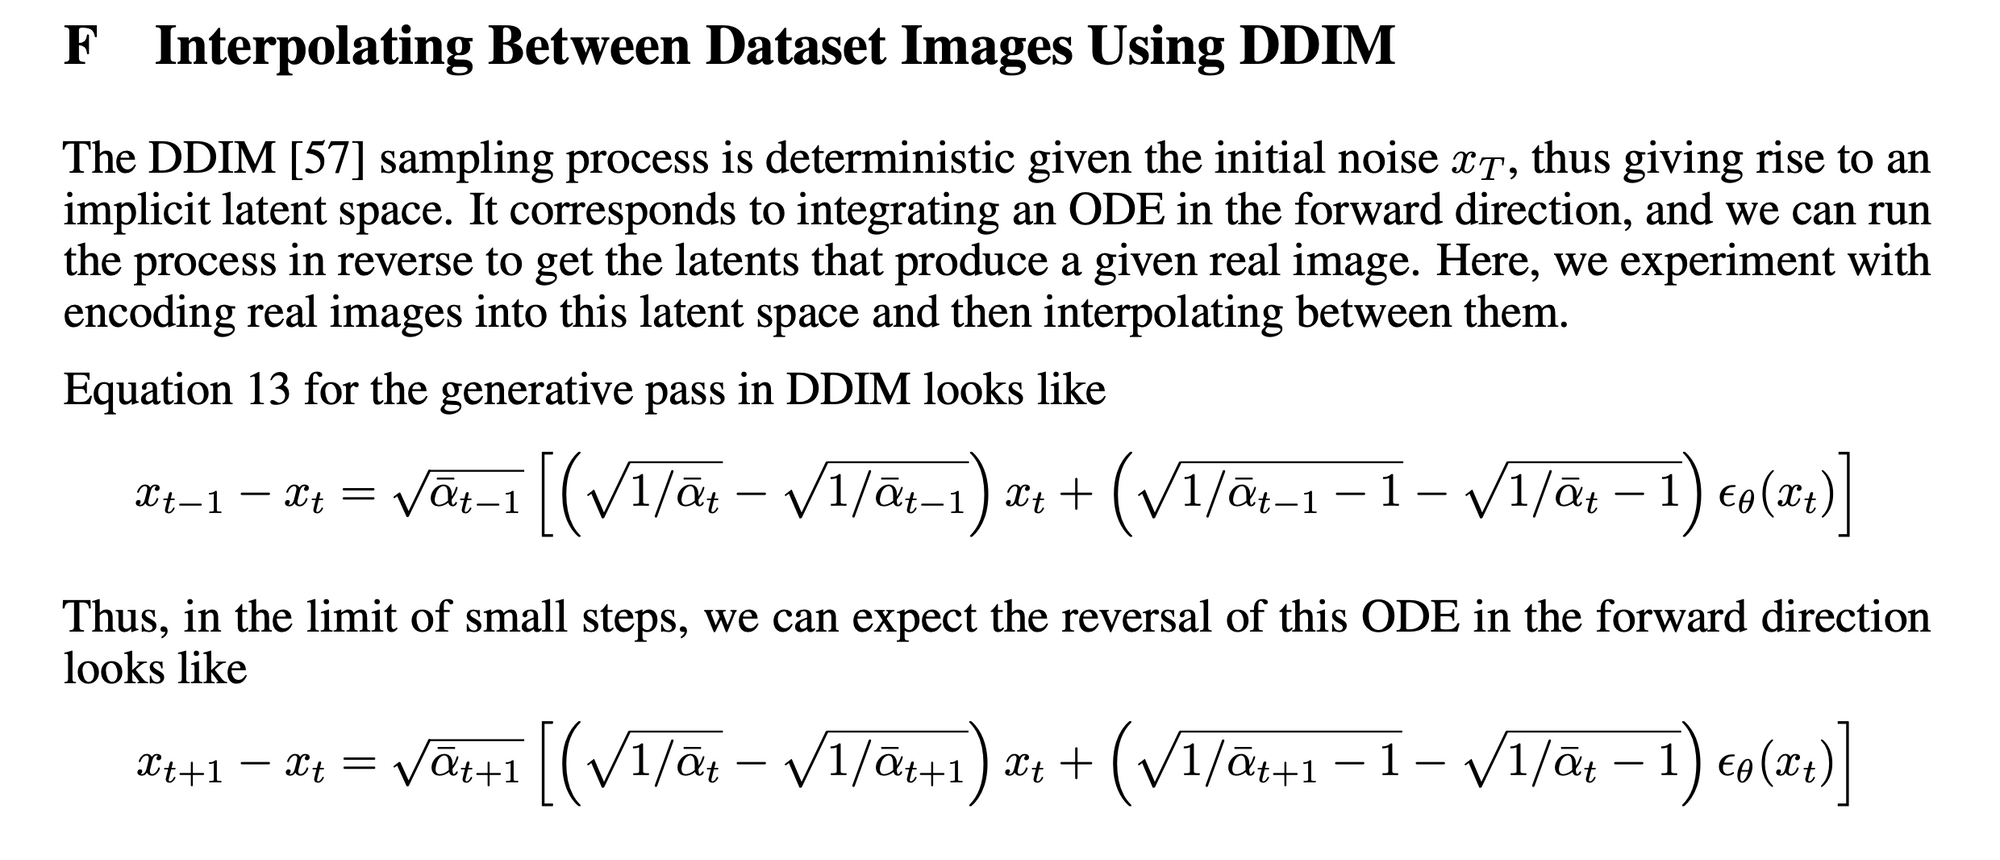

In [2]:
def backward_ddim(x_t, alpha_t: "alpha_t", alpha_tm1: "alpha_{t-1}", eps_xt):
    """ from noise to image"""
    return (
        alpha_tm1**0.5
        * (
            (alpha_t**-0.5 - alpha_tm1**-0.5) * x_t
            + ((1 / alpha_tm1 - 1) ** 0.5 - (1 / alpha_t - 1) ** 0.5) * eps_xt
        )
        + x_t
    )

def forward_ddim(x_t, alpha_t: "alpha_t", alpha_tp1: "alpha_{t+1}", eps_xt):
    """ from image to noise, it's the same as backward_ddim"""
    return backward_ddim(x_t, alpha_t, alpha_tp1, eps_xt)

Image.open('docs/DDIM.png')

In [3]:
class StableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        safety_checker: StableDiffusionSafetyChecker = None,
        feature_extractor: CLIPFeatureExtractor = None,
    ):
        super().__init__()

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            # safety_checker=safety_checker,
            # feature_extractor=feature_extractor,
        )
        self.forward_diffusion = partial(self.backward_diffusion, reverse_process=True)
    


    @torch.inference_mode()
    def get_text_embedding(self, prompt):
        text_input_ids = self.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids
        text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]
        return text_embeddings
    
    @torch.inference_mode()
    def get_image_latents(self, image, sample=True, rng_generator=None):
        encoding_dist = self.vae.encode(image).latent_dist
        if sample:
            encoding = encoding_dist.sample(generator=rng_generator)
        else:
            encoding = encoding_dist.mode()
        latents = encoding * 0.18215
        return latents


    @torch.inference_mode()
    def backward_diffusion(
        self,
        use_old_emb_i=25,
        text_embeddings=None,
        old_text_embeddings=None,
        new_text_embeddings=None,
        latents: Optional[torch.FloatTensor] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        reverse_process: True = False,
        **kwargs,
    ):
        """ Generate image from text prompt and latents
        """
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        # Some schedulers like PNDM have timesteps as arrays
        # It's more optimized to move all timesteps to correct device beforehand
        timesteps_tensor = self.scheduler.timesteps.to(self.device)
        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        if old_text_embeddings is not None and new_text_embeddings is not None:
            prompt_to_prompt = True
        else:
            prompt_to_prompt = False


        for i, t in enumerate(self.progress_bar(timesteps_tensor if not reverse_process else reversed(timesteps_tensor))):
            if prompt_to_prompt:
                if i < use_old_emb_i:
                    text_embeddings = old_text_embeddings
                else:
                    text_embeddings = new_text_embeddings

            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            ).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            prev_timestep = (
                t
                - self.scheduler.config.num_train_timesteps
                // self.scheduler.num_inference_steps
            )
            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)
            
            # ddim 
            alpha_prod_t = self.scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = (
                self.scheduler.alphas_cumprod[prev_timestep]
                if prev_timestep >= 0
                else self.scheduler.final_alpha_cumprod
            )
            if reverse_process:
                alpha_prod_t, alpha_prod_t_prev = alpha_prod_t_prev, alpha_prod_t
            latents = backward_ddim(
                x_t=latents,
                alpha_t=alpha_prod_t,
                alpha_tm1=alpha_prod_t_prev,
                eps_xt=noise_pred,
            )
        return latents

    
    @torch.inference_mode()
    def decode_image(self, latents: torch.FloatTensor, **kwargs) -> List["PIL_IMAGE"]:
        scaled_latents = 1 / 0.18215 * latents
        image = [
            self.vae.decode(scaled_latents[i : i + 1]).sample for i in range(len(latents))
        ]
        image = torch.cat(image, dim=0)
        return image

    @torch.inference_mode()
    def torch_to_numpy(self, image) -> List["PIL_IMAGE"]:
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        return image

In [4]:
pipe = StableDiffusionPipeline.from_pretrained(path)
pipe.scheduler = DDIMScheduler.from_config(path / "scheduler")
pipe = pipe.to("cuda")

The config attributes {'skip_prk_steps': True} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [5]:
# run this when you modify the code
pipe2 = StableDiffusionPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    scheduler=pipe.scheduler,
)
pipe = pipe2

In [6]:
def load_img(path, target_size=512):
    """Load an image, resize and output -1..1"""
    image = Image.open(path).convert("RGB")

    tform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ]
    )
    image = tform(image)
    return 2.0 * image - 1.0


impath = Path("~/images/Official_portrait_of_Barack_Obama.jpg").expanduser()
img = load_img(impath).unsqueeze(0).to("cuda")

In [7]:
prompt = "A photo of Barack Obama"
alternate_prompt = "A photo of Barack Obama smiling with a big grin"
text_embeddings = pipe.get_text_embedding(prompt)
alternate_embeddings = pipe.get_text_embedding(alternate_prompt)

In [8]:
image_latents = pipe.get_image_latents(img, rng_generator=torch.Generator(device=pipe.device).manual_seed(0))

In [9]:
# sanity check
image_latents.var()

tensor(0.8567, device='cuda:0')

In [10]:
reversed_latents = pipe.forward_diffusion(
    latents=image_latents,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=50,
)


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
# sanity check
reversed_latents.var()

tensor(0.9381, device='cuda:0')

In [12]:
reconstructed_latents = pipe.backward_diffusion(
    latents=reversed_latents,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=50,
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
alternate_reconstruction_latents = pipe.backward_diffusion(
    latents=reversed_latents,
    text_embeddings=alternate_embeddings,
    guidance_scale=1,
    num_inference_steps=50,
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
# helper function to show images
def latents_to_imgs(latents):
    x = pipe.decode_image(latents)
    x = pipe.torch_to_numpy(x)
    x = pipe.numpy_to_pil(x)
    return x

# original

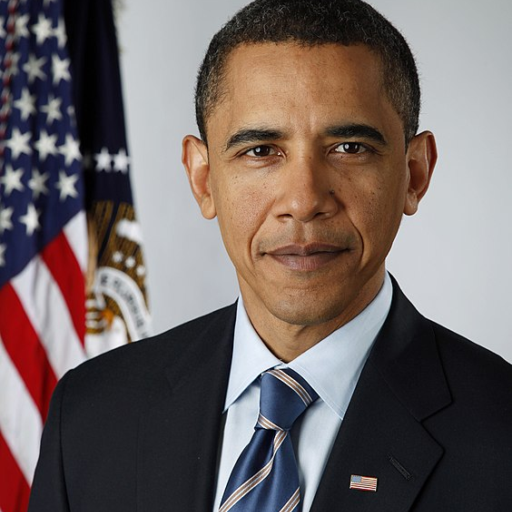

In [15]:
pipe.numpy_to_pil(pipe.torch_to_numpy(img))[0]

# vae reconstruction

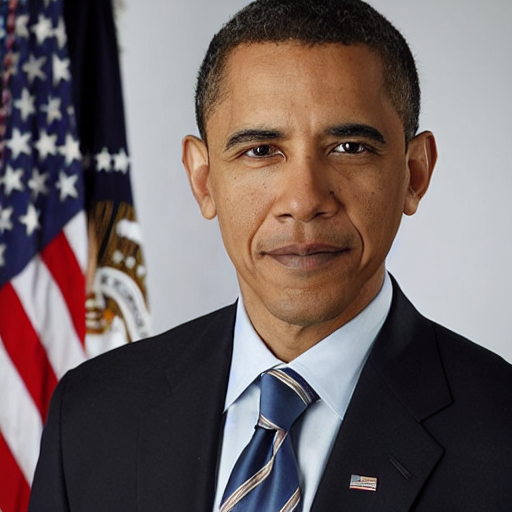

In [16]:
latents_to_imgs(image_latents)[0]

# ddim reconstruction

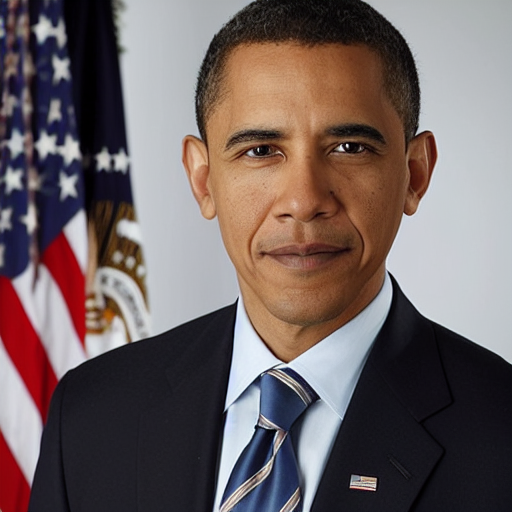

In [17]:
latents_to_imgs(reconstructed_latents)[0]

# alternate reconstruction 

This is prompt to prompt [https://arxiv.org/abs/2208.01626], but without any attention manipulation

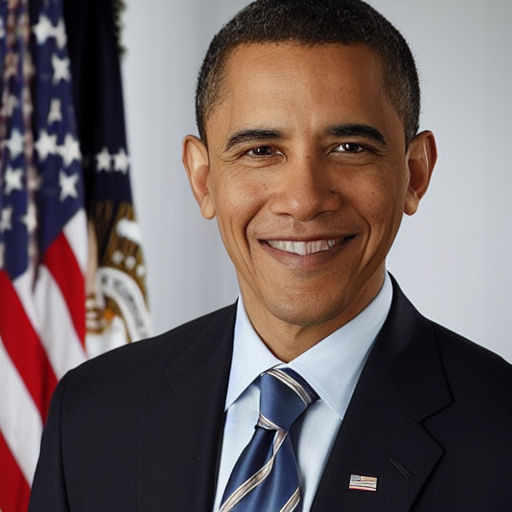

In [18]:
latents_to_imgs(alternate_reconstruction_latents)[0]